##Importing required libraries

In [8]:
# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# ML Libraries
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
#from yellowbrick.classifier import ClassificationReport
from sklearn import metrics

##Loading preprocesses data for the classification purpose.

In [10]:
crime = pd.read_pickle("drive/My Drive/Colab Notebooks/CMPE_255_Project/Chicago_Crime_Processed_Data.pkl")

In [11]:
crime.head()

,IUCR,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude,Month,Day_num,Time,day_of_week,primary_type_grouped,zone,Count_CrimeType_Column
0,0486,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,2015,41.815117,-87.670000,9,5,13,Saturday,NON-CRIMINAL_ASSAULT,South,1640154.0
1,0870,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,2015,41.895080,-87.765400,9,4,11,Friday,THEFT,North,2327482.0
2,2023,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,2015,41.937406,-87.716650,9,5,12,Saturday,NARCOTIC_OFFENSE,West,661033.0
3,0560,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,2015,41.881903,-87.755121,9,5,13,Saturday,NON-CRIMINAL_ASSAULT,North,1640154.0
4,0610,FORCIBLE ENTRY,RESIDENCE,False,False,614,6.0,21.0,71.0,05,2015,41.744379,-87.658431,9,5,10,Saturday,THEFT,South,2327482.0


In [12]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6626783 entries, 0 to 6626782
Data columns (total 20 columns):
IUCR                      object
Description               object
Location Description      object
Arrest                    bool
Domestic                  bool
Beat                      int64
District                  float64
Ward                      float64
Community Area            float64
FBI Code                  object
Year                      int64
Latitude                  float64
Longitude                 float64
Month                     int64
Day_num                   int64
Time                      int64
day_of_week               object
primary_type_grouped      object
zone                      object
Count_CrimeType_Column    float64
dtypes: bool(2), float64(6), int64(5), object(7)
memory usage: 922.7+ MB


In [13]:
crime.isnull().sum().sum()

5348

In [14]:
crime.apply(lambda x: sum(x.isnull()),axis=0)

IUCR                         0
Description                  0
Location Description         0
Arrest                       0
Domestic                     0
Beat                         0
District                     0
Ward                         0
Community Area               0
FBI Code                     0
Year                         0
Latitude                     0
Longitude                    0
Month                        0
Day_num                      0
Time                         0
day_of_week                  0
primary_type_grouped      2674
zone                         0
Count_CrimeType_Column    2674
dtype: int64

In [15]:
crime['primary_type_grouped'].unique()

array(['NON-CRIMINAL_ASSAULT', 'THEFT', 'NARCOTIC_OFFENSE',
       'OTHER_OFFENSE', 'CRIMINAL_OFFENSE', 'WEAPONS_OFFENSE',
       'SEXUAL_OFFENSE', 'HUMAN_TRAFFICKING_OFFENSE', nan], dtype=object)

In [16]:
cime= crime.dropna(inplace=True)
crime = crime.reset_index(drop=True)

In [17]:
crime['primary_type_grouped'].unique()

array(['NON-CRIMINAL_ASSAULT', 'THEFT', 'NARCOTIC_OFFENSE',
       'OTHER_OFFENSE', 'CRIMINAL_OFFENSE', 'WEAPONS_OFFENSE',
       'SEXUAL_OFFENSE', 'HUMAN_TRAFFICKING_OFFENSE'], dtype=object)

In [18]:
crime.shape

(6624109, 20)

##Data processing further for applying random forest model.

In [21]:
# Convert Categorical Attributes to Numerical
for col_name in crime.columns:
    if(crime[col_name].dtype == 'object'):
        crime[col_name]= crime[col_name].astype('category')
        crime[col_name] = crime[col_name].cat.codes

In [22]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6624109 entries, 0 to 6624108
Data columns (total 20 columns):
IUCR                      int16
Description               int16
Location Description      int16
Arrest                    bool
Domestic                  bool
Beat                      int64
District                  float64
Ward                      float64
Community Area            float64
FBI Code                  int8
Year                      int64
Latitude                  float64
Longitude                 float64
Month                     int64
Day_num                   int64
Time                      int64
day_of_week               int8
primary_type_grouped      int8
zone                      int8
Count_CrimeType_Column    float64
dtypes: bool(2), float64(6), int16(3), int64(5), int8(4)
memory usage: 631.7 MB


##To check correlation between different variables.

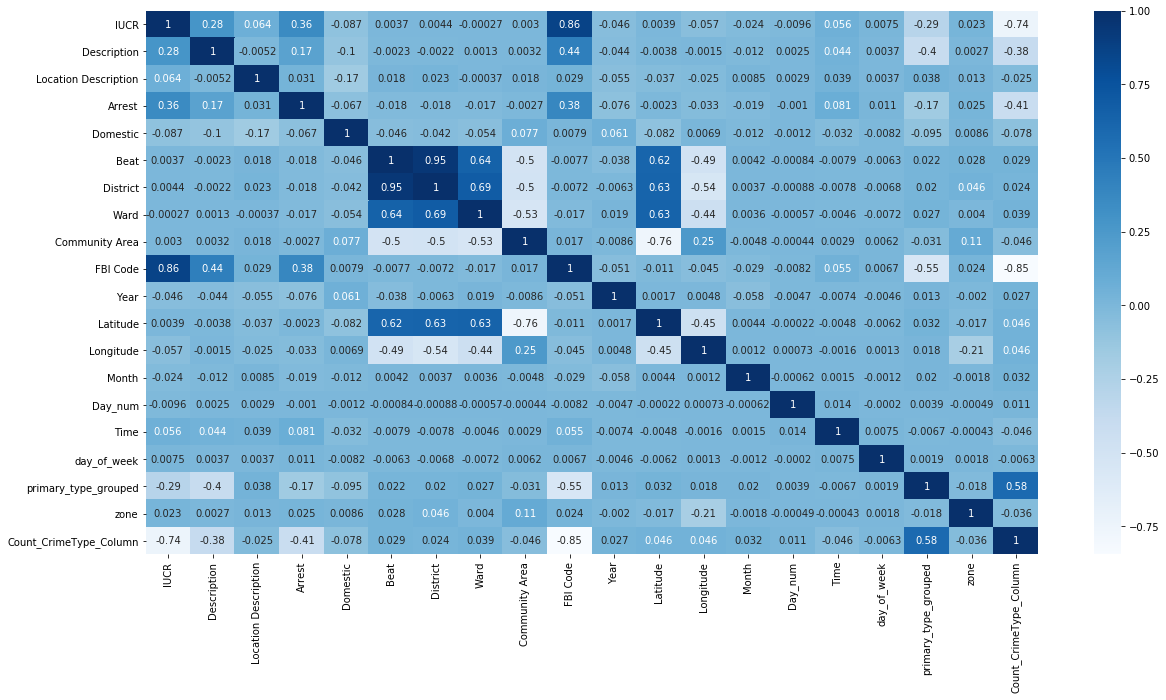

In [23]:
# Feature Selection using Filter Method 
# Split Dataframe to target class and features
X_fs = crime.drop(['primary_type_grouped'], axis=1)
Y_fs = crime['primary_type_grouped']

#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = crime.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [24]:
#Correlation with output variable
cor_target = abs(cor['primary_type_grouped'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.01]
relevant_features

IUCR                      0.292668
Description               0.398370
Location Description      0.038127
Arrest                    0.166601
Domestic                  0.095439
Beat                      0.022295
District                  0.019958
Ward                      0.027361
Community Area            0.031119
FBI Code                  0.548101
Year                      0.012579
Latitude                  0.031977
Longitude                 0.017794
Month                     0.019630
primary_type_grouped      1.000000
zone                      0.017890
Count_CrimeType_Column    0.582641
Name: primary_type_grouped, dtype: float64

##We can see that the three features are highly related with target crime type "primary_type_grouped" which is obvious as these are the attribuets which are updated after crime happened .Attributes like "FBI Code", "ICUR" and "Description". So for this classification we will be usig attributes which are constant and before crime to predict a crime type to take needed precautions like increasing pnumber of police and so forth. 

In [25]:
# At Current Point, the attributes is select manually based on Feature Selection Part. 
#Features = ["IUCR", "Location Description", "FBI Code"]
Features = ["District","Ward","Community Area","Latitude","Longitude","Month","Year","Time","zone","Location Description","Beat"]
print('Full Features: ', Features)

Full Features:  ['District', 'Ward', 'Community Area', 'Latitude', 'Longitude', 'Month', 'Year', 'Time', 'zone', 'Location Description', 'Beat']


In [26]:
target ='primary_type_grouped'

##Splitting data in training and testing.

In [27]:
#Split dataset to Training Set & Test Set
x, y = train_test_split(crime, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 3)

x1 = x[Features]    #Features to train
x2 = x[target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Feature Set Used    :  ['District', 'Ward', 'Community Area', 'Latitude', 'Longitude', 'Month', 'Year', 'Time', 'zone', 'Location Description', 'Beat']
Target Class        :  primary_type_grouped
Training Set Size   :  (5299287, 20)
Test Set Size       :  (1324822, 20)


In [28]:
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(40,), 
                         random_state=1,
                         max_iter=1000                         
                        )

# Model Training
nn_model.fit(X=x1,
             y=x2)

# Prediction
result = nn_model.predict(y[Features]) 

In [29]:
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Neural Network Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


========== Neural Network Results ==========
Accuracy    :  0.37084680055131936
Recall      :  0.37084680055131936
Precision   :  0.3089743622311793
F1 Score    :  0.37084680055131936
Confusion Matrix: 
[[    34      0   5088  16914      0      0 223713      0]
 [     2      0     86   1492      0      0   8713      0]
 [    15      0  15783   7562      0      0 108808      0]
 [    59      0  11829  41909      0      0 274794      0]
 [     9      0   3049   7788      0      0  91871      0]
 [     2      0   1802   1739      0      0  18862      0]
 [    21      0  12030  20673      0      0 433580      0]
 [     2      0   1124   1679      0      0  13790      0]]
